In [1]:
# Detect environment
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Install required packages
    !pip install underthesea pyvi -q
    
    # Set paths for Colab
    BASE_PATH = '/content/drive/MyDrive/learniverse-ai'
else:
    # Local paths
    BASE_PATH = '..'  # Assuming notebook is in notebooks/

print(f"Running in: {'Google Colab' if IN_COLAB else 'Local Environment'}")
print(f"Base path: {BASE_PATH}")

Running in: Local Environment
Base path: ..


In [2]:
# Import libraries
import os
import sys
import json
import pickle
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    f1_score, 
    precision_score, 
    recall_score,
    confusion_matrix,
    multilabel_confusion_matrix
)

# Add src to path
sys.path.insert(0, os.path.join(BASE_PATH, 'src'))

from preprocessing.text_preprocessor import VietnameseTextPreprocessor
from models.bilstm import BiLSTMClassifier, MultiLabelFocalLoss, get_model_config
from models.dataset import Vocabulary, CommentDataset, collate_fn

# Set seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
VRAM: 3.7 GB


## 1. Load and Explore Data

### Expected Data Format

**ViHSD:**
- Columns: `free_text`, `label_id` (0=CLEAN, 1=OFFENSIVE, 2=HATE)

**ViCTSD:**
- Columns: `Comment`, `Constructive`, `Toxic`

In [3]:
# Define paths
DATA_RAW_PATH = Path(BASE_PATH) / 'data' / 'raw'
DATA_PROCESSED_PATH = Path(BASE_PATH) / 'data' / 'processed'
MODELS_PATH = Path(BASE_PATH) / 'data' / 'models'

# Create directories if needed
DATA_PROCESSED_PATH.mkdir(parents=True, exist_ok=True)
MODELS_PATH.mkdir(parents=True, exist_ok=True)

print(f"Raw data path: {DATA_RAW_PATH}")
print(f"Processed data path: {DATA_PROCESSED_PATH}")
print(f"Models path: {MODELS_PATH}")

Raw data path: ../data/raw
Processed data path: ../data/processed
Models path: ../data/models


In [4]:
# List available files in raw data folder
print("Files in raw data folder:")
if DATA_RAW_PATH.exists():
    for f in DATA_RAW_PATH.iterdir():
        print(f"  - {f.name}")
else:
    print("  Raw data folder not found!")
    print(f"  Please create: {DATA_RAW_PATH}")

Files in raw data folder:
  - vihsd_dev.csv
  - victsd_dev.csv
  - vihsd_train.csv
  - victsd_train.csv
  - victsd_test.csv
  - vihsd_test.csv
  - .gitkeep


In [5]:
def load_vihsd(data_path: Path) -> pd.DataFrame:
    """
    Load ViHSD dataset.
    Expected files: vihsd_train.csv, vihsd_dev.csv, vihsd_test.csv
    Labels: 0=CLEAN, 1=OFFENSIVE, 2=HATE (3-class classification)
    """
    dfs = []
    
    for split in ['train', 'dev', 'test']:
        file_path = data_path / f'vihsd_{split}.csv'
        if file_path.exists():
            df = pd.read_csv(file_path)
            df['split'] = split
            dfs.append(df)
            print(f"Loaded {split}: {len(df)} samples")
        else:
            print(f"Warning: {file_path} not found")
    
    if not dfs:
        return None
    
    combined = pd.concat(dfs, ignore_index=True)
    
    # Rename columns to standard format
    combined = combined.rename(columns={
        'free_text': 'text',
        'label_id': 'label'  # Keep original: 0=CLEAN, 1=OFFENSIVE, 2=HATE
    })
    
    combined['source'] = 'vihsd'
    
    return combined


def load_victsd(data_path: Path) -> pd.DataFrame:
    """
    Load UIT-ViCTSD dataset.
    Expected files: victsd_train.csv, victsd_dev.csv, victsd_test.csv
    Columns: Comment, Constructiveness, Toxicity, Title, Topic
    Maps Toxicity to OFFENSIVE (label=1) to match ViHSD format
    """
    dfs = []
    
    for split in ['train', 'dev', 'test']:
        file_path = data_path / f'victsd_{split}.csv'
        if file_path.exists():
            df = pd.read_csv(file_path)
            df['split'] = split
            dfs.append(df)
            print(f"Loaded {split}: {len(df)} samples")
        else:
            print(f"Warning: {file_path} not found")
    
    if not dfs:
        return None
    
    combined = pd.concat(dfs, ignore_index=True)
    
    # Print columns for debugging
    print(f"ViCTSD columns: {combined.columns.tolist()}")
    
    # Rename columns to standard format
    combined = combined.rename(columns={
        'Comment': 'text',
        'Toxicity': 'toxicity'
    })
    
    # Map ViCTSD toxicity to 3-class labels
    # toxicity=0 → CLEAN (0), toxicity=1 → OFFENSIVE (1)
    # ViCTSD doesn't have hate speech, so max label is 1
    combined['label'] = combined['toxicity'].astype(int)
    combined['source'] = 'victsd'
    
    return combined

In [6]:
# Load datasets
print("Loading ViHSD...")
vihsd_df = load_vihsd(DATA_RAW_PATH)

print("\nLoading ViCTSD...")
victsd_df = load_victsd(DATA_RAW_PATH)

# Combine datasets
dfs_to_combine = []
if vihsd_df is not None:
    dfs_to_combine.append(vihsd_df[['text', 'label', 'split', 'source']])
if victsd_df is not None:
    dfs_to_combine.append(victsd_df[['text', 'label', 'split', 'source']])

if dfs_to_combine:
    df = pd.concat(dfs_to_combine, ignore_index=True)
    print(f"\nCombined dataset: {len(df)} samples")
    print("\nLabel distribution:")
    print(df['label'].value_counts().sort_index())
    print("\nLabel mapping: 0=CLEAN, 1=OFFENSIVE, 2=HATE")
else:
    print("\n⚠️ No datasets found! Please add data files to data/raw/")
    print("Expected files:")
    print("  - vihsd_train.csv, vihsd_dev.csv, vihsd_test.csv")
    print("  - victsd_train.csv, victsd_dev.csv, victsd_test.csv")
    df = None

Loading ViHSD...
Loaded train: 24055 samples
Loaded dev: 2672 samples
Loaded test: 6680 samples

Loading ViCTSD...
Loaded train: 7000 samples
Loaded dev: 2000 samples
Loaded test: 1000 samples
ViCTSD columns: ['Unnamed: 0', 'Comment', 'Constructiveness', 'Toxicity', 'Title', 'Topic', 'split']

Combined dataset: 43407 samples

Label distribution:
label
0    36530
1     3363
2     3514
Name: count, dtype: int64

Label mapping: 0=CLEAN, 1=OFFENSIVE, 2=HATE


In [7]:
# Explore data
if df is not None:
    print("Dataset Info:")
    print(df.info())
    
    print("\nSample data:")
    display(df.head(10))
    
    print("\n3-Class Label Distribution:")
    label_counts = df['label'].value_counts().sort_index()
    for label_val, count in label_counts.items():
        label_name = ['CLEAN', 'OFFENSIVE', 'HATE'][label_val]
        pct = (count / len(df)) * 100
        print(f"  {label_val} ({label_name}): {count} ({pct:.1f}%)")
    
    print("\nBy source:")
    print(df.groupby('source')['label'].value_counts().unstack(fill_value=0))

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43407 entries, 0 to 43406
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    43405 non-null  object
 1   label   43407 non-null  int64 
 2   split   43407 non-null  object
 3   source  43407 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.3+ MB
None

Sample data:


,text,label,split,source
0,Em được làm fan cứng luôn rồi nè ❤️ reaction q...,0,train,vihsd
1,Đúng là bọn mắt híp lò xo thụt :))) bên việt n...,2,train,vihsd
2,Đậu Văn Cường giờ giống thằng sida hơn à,0,train,vihsd
3,CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯ...,2,train,vihsd
4,Từ lý thuyết đến thực hành là cả 1 câu chuyện ...,0,train,vihsd
5,Coronavirus is manmade,0,train,vihsd
6,Đố chúng m nhận ra ai,0,train,vihsd
7,Lúp lúp như chó .,1,train,vihsd
8,🥰🥰🥰,0,train,vihsd
9,"Thế mà mình nói mấy thằng bắc kì, bọn đó lại b...",2,train,vihsd



3-Class Label Distribution:
  0 (CLEAN): 36530 (84.2%)
  1 (OFFENSIVE): 3363 (7.7%)
  2 (HATE): 3514 (8.1%)

By source:
label       0     1     2
source                   
victsd   8899  1101     0
vihsd   27631  2262  3514


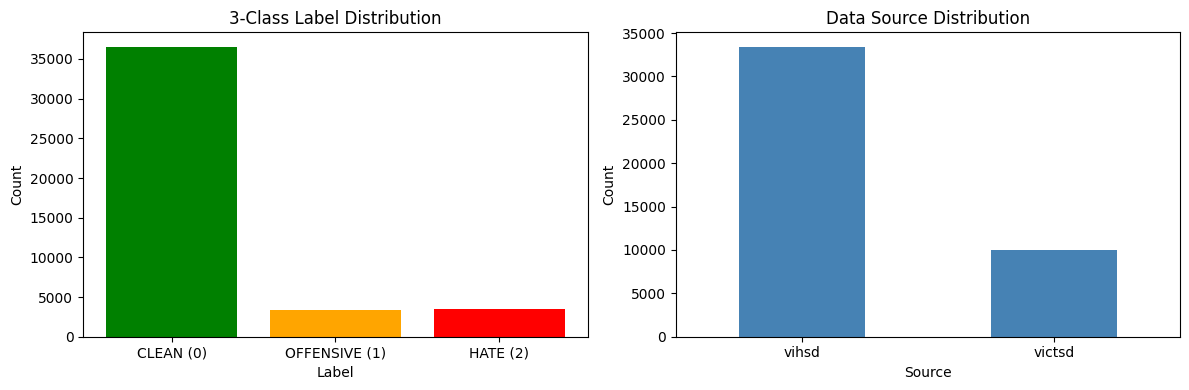

In [8]:
# Visualize label distribution
if df is not None:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # 3-class distribution
    ax1 = axes[0]
    label_counts = df['label'].value_counts().sort_index()
    colors = ['green', 'orange', 'red']
    label_names = ['CLEAN (0)', 'OFFENSIVE (1)', 'HATE (2)']
    ax1.bar(range(len(label_counts)), label_counts.values, color=colors[:len(label_counts)])
    ax1.set_xticks(range(len(label_counts)))
    ax1.set_xticklabels([label_names[i] for i in label_counts.index])
    ax1.set_title('3-Class Label Distribution')
    ax1.set_xlabel('Label')
    ax1.set_ylabel('Count')
    
    # Source distribution
    ax2 = axes[1]
    df['source'].value_counts().plot(kind='bar', ax=ax2, color='steelblue')
    ax2.set_title('Data Source Distribution')
    ax2.set_xlabel('Source')
    ax2.set_ylabel('Count')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.show()

## 2. Preprocess Data

In [9]:
# Initialize preprocessor
preprocessor = VietnameseTextPreprocessor(
    lowercase=True,
    remove_urls=True,
    remove_emails=True,
    remove_phones=True,
    remove_emojis=False,  # Keep emojis - they can indicate sentiment
    normalize_teencode=True,
    normalize_repeated_chars=True,
    word_segmentation=True,  # Vietnamese word segmentation
)

print("Preprocessor initialized")

Preprocessor initialized


In [10]:
# Apply preprocessing
if df is not None:
    print("Preprocessing texts...")
    tqdm.pandas(desc="Preprocessing")
    
    df['text_processed'] = df['text'].progress_apply(preprocessor.preprocess)
    
    # Show examples
    print("\nPreprocessing examples:")
    for i in range(min(5, len(df))):
        print(f"\nOriginal:  {df.iloc[i]['text'][:100]}...")
        print(f"Processed: {df.iloc[i]['text_processed'][:100]}...")

Preprocessing texts...


Preprocessing:   0%|          | 0/43407 [00:00<?, ?it/s]


Preprocessing examples:

Original:  Em được làm fan cứng luôn rồi nè ❤️ reaction quá hay quá cute coi mấy giờ này quá hợp lí =]]]...
Processed: em được làm fan cứng luôn rồi nè ❤_️ reaction quá hay quá cute coi mấy giờ này quá hợp_lí = ] ]...

Original:  Đúng là bọn mắt híp lò xo thụt :))) bên việt nam t cái này ra cách đây 10 năm r và bọn t gọi là cái ...
Processed: đúng là bọn mắt híp lò_xo thụt :)) bên việt_nam tao cái này ra cách đây 10 năm rồi và bọn tao gọi_là...

Original:  Đậu Văn Cường giờ giống thằng sida hơn à...
Processed: đậu văn_cường giờ giống thằng sida hơn à...

Original:  CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯỚC VN BAN THƯỞNG....
Processed: côn_đồ cục súc vô_nhân_tính đề_nghi vn . nhà_nước vn ban thưởng ....

Original:  Từ lý thuyết đến thực hành là cả 1 câu chuyện dài =))...
Processed: từ lý_thuyết đến thực_hành là cả 1 câu_chuyện dài =))...


In [11]:
# Remove empty texts and corrupted long texts after preprocessing
if df is not None:
    original_len = len(df)
    
    # Calculate text length first
    df['text_length'] = df['text_processed'].str.split().str.len()
    
    # Filter out empty texts and texts that are too long (corrupted records)
    MAX_ALLOWED_LENGTH = 500
    df = df[(df['text_processed'].str.len() > 0) & (df['text_length'] <= MAX_ALLOWED_LENGTH)].reset_index(drop=True)
    
    removed = original_len - len(df)
    print(f"Removed {removed} records (empty or corrupted with length > {MAX_ALLOWED_LENGTH})")
    print(f"Final dataset size: {len(df)}")

Removed 5 records (empty or corrupted with length > 500)
Final dataset size: 43402


Text length statistics:
count    43402.000000
mean        14.447929
std         18.481110
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max        421.000000
Name: text_length, dtype: float64


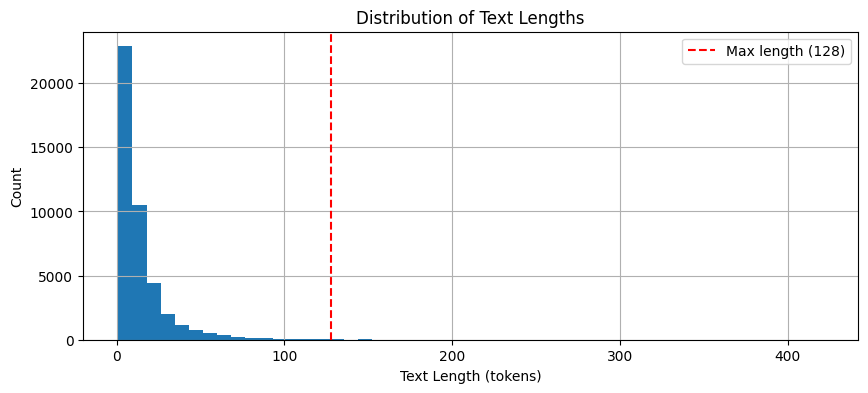


99.6% of texts are within 128 tokens


In [12]:
# Analyze text lengths
if df is not None:
    df['text_length'] = df['text_processed'].str.split().str.len()
    
    print("Text length statistics:")
    print(df['text_length'].describe())
    
    # Plot distribution
    fig, ax = plt.subplots(figsize=(10, 4))
    df['text_length'].hist(bins=50, ax=ax)
    ax.axvline(x=128, color='r', linestyle='--', label='Max length (128)')
    ax.set_xlabel('Text Length (tokens)')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Text Lengths')
    ax.legend()
    plt.show()
    
    # Percentage within max length
    max_len = 128
    pct_within = (df['text_length'] <= max_len).mean() * 100
    print(f"\n{pct_within:.1f}% of texts are within {max_len} tokens")

In [13]:
# Rows with very long texts
long_text_rows = df[df['text_length'] > 500]

if long_text_rows.empty:
    print("No rows found with text_length over 1000.")
else:
    display(long_text_rows)

No rows found with text_length over 1000.


## 3. Prepare Train/Val/Test Splits

In [14]:
# Split data
if df is not None:
    # Use original splits if available, otherwise create new splits
    if 'split' in df.columns and df['split'].nunique() > 1:
        train_df = df[df['split'] == 'train'].reset_index(drop=True)
        val_df = df[df['split'] == 'dev'].reset_index(drop=True)
        test_df = df[df['split'] == 'test'].reset_index(drop=True)
        print("Using original splits")
    else:
        # Create new splits: 80% train, 10% val, 10% test
        train_df, temp_df = train_test_split(
            df, test_size=0.2, random_state=SEED, 
            stratify=df['label']  # Stratify by label
        )
        val_df, test_df = train_test_split(
            temp_df, test_size=0.5, random_state=SEED,
            stratify=temp_df['label']
        )
        train_df = train_df.reset_index(drop=True)
        val_df = val_df.reset_index(drop=True)
        test_df = test_df.reset_index(drop=True)
        print("Created new splits")
    
    print(f"\nTrain: {len(train_df)} samples")
    print(f"Val:   {len(val_df)} samples")
    print(f"Test:  {len(test_df)} samples")
    
    # Show label distribution in each split
    print("\n3-Class Label Distribution by Split:")
    for name, split_df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
        print(f"\n{name}:")
        label_counts = split_df['label'].value_counts().sort_index()
        for label_val, count in label_counts.items():
            label_name = ['CLEAN', 'OFFENSIVE', 'HATE'][label_val]
            pct = (count / len(split_df)) * 100
            print(f"  {label_val} ({label_name}): {count} ({pct:.1f}%)")

Using original splits

Train: 31050 samples
Val:   4672 samples
Test:  7680 samples

3-Class Label Distribution by Split:

Train:
  0 (CLEAN): 26130 (84.2%)
  1 (OFFENSIVE): 2364 (7.6%)
  2 (HATE): 2556 (8.2%)

Val:
  0 (CLEAN): 3958 (84.7%)
  1 (OFFENSIVE): 444 (9.5%)
  2 (HATE): 270 (5.8%)

Test:
  0 (CLEAN): 6438 (83.8%)
  1 (OFFENSIVE): 554 (7.2%)
  2 (HATE): 688 (9.0%)


## 4. Build Vocabulary and Create Datasets

In [15]:
# Configuration
MAX_VOCAB_SIZE = 30000
MIN_FREQ = 2
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 32

print(f"Max vocabulary size: {MAX_VOCAB_SIZE}")
print(f"Min token frequency: {MIN_FREQ}")
print(f"Max sequence length: {MAX_SEQ_LENGTH}")
print(f"Batch size: {BATCH_SIZE}")

Max vocabulary size: 30000
Min token frequency: 2
Max sequence length: 128
Batch size: 32


In [16]:
# Build vocabulary from training data only
if train_df is not None:
    print("Building vocabulary...")
    vocab = Vocabulary(max_size=MAX_VOCAB_SIZE, min_freq=MIN_FREQ)
    vocab.build(train_df['text_processed'].tolist())
    
    print(f"Vocabulary size: {len(vocab)}")
    
    # Save vocabulary
    vocab_path = MODELS_PATH / 'vocab.json'
    vocab.save(vocab_path)
    print(f"Vocabulary saved to: {vocab_path}")

Building vocabulary...
Vocabulary size: 12552
Vocabulary saved to: ../data/models/vocab.json


In [17]:
# Create datasets - 3-CLASS CLASSIFICATION
# Labels: 0=CLEAN, 1=OFFENSIVE, 2=HATE
NUM_CLASSES = 3
LABEL_NAMES = ['CLEAN', 'OFFENSIVE', 'HATE']

if train_df is not None:
    train_dataset = CommentDataset(
        texts=train_df['text_processed'].tolist(),
        labels=train_df['label'].tolist(),  # Single integer label (0, 1, or 2)
        vocab=vocab,
        max_length=MAX_SEQ_LENGTH,
    )
    
    val_dataset = CommentDataset(
        texts=val_df['text_processed'].tolist(),
        labels=val_df['label'].tolist(),
        vocab=vocab,
        max_length=MAX_SEQ_LENGTH,
    )
    
    test_dataset = CommentDataset(
        texts=test_df['text_processed'].tolist(),
        labels=test_df['label'].tolist(),
        vocab=vocab,
        max_length=MAX_SEQ_LENGTH,
    )
    
    print(f"Train dataset: {len(train_dataset)} samples")
    print(f"Val dataset: {len(val_dataset)} samples")
    print(f"Test dataset: {len(test_dataset)} samples")
    print(f"Task: 3-class classification - {LABEL_NAMES}")

Train dataset: 31050 samples
Val dataset: 4672 samples
Test dataset: 7680 samples
Task: 3-class classification - ['CLEAN', 'OFFENSIVE', 'HATE']


In [ ]:
# Create dataloaders
if train_df is not None:
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=0,  # Disable multiprocessing to avoid Python 3.13 issues
        pin_memory=True,
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=0,  # Disable multiprocessing to avoid Python 3.13 issues
        pin_memory=True,
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=0,  # Disable multiprocessing to avoid Python 3.13 issues
        pin_memory=True,
    )
    
    print(f"Train batches: {len(train_loader)}")
    print(f"Val batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")

Train batches: 971
Val batches: 146
Test batches: 240


## 5. Initialize Model

In [31]:
# Model configuration - using small model to reduce overfitting
model_config = get_model_config('large')  # 'small', 'base', or 'large'
print("Model configuration:")
for k, v in model_config.items():
    print(f"  {k}: {v}")

Model configuration:
  embedding_dim: 512
  hidden_dim: 256
  num_layers: 3
  dropout: 0.5


In [32]:
# Create model for 3-class classification
if vocab is not None:
    model = BiLSTMClassifier(
        vocab_size=len(vocab),
        num_labels=NUM_CLASSES,  # 3 classes: CLEAN, OFFENSIVE, HATE
        padding_idx=vocab.pad_idx,
        **model_config
    )
    
    model = model.to(device)
    
    # Print model summary
    print(model)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Estimated size: {total_params * 4 / 1024**2:.1f} MB")
    print(f"\nOutput: {NUM_CLASSES} classes - {LABEL_NAMES}")

BiLSTMClassifier(
  (embedding): Embedding(12552, 512, padding_idx=0)
  (lstm): LSTM(512, 256, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (attention): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=1, bias=False)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=3, bias=True)
  )
)

Total parameters: 11,421,187
Trainable parameters: 11,421,187
Estimated size: 43.6 MB

Output: 3 classes - ['CLEAN', 'OFFENSIVE', 'HATE']


In [33]:
# Loss function and optimizer for 3-class classification
# Using CrossEntropyLoss with class weights to handle imbalance
class_counts = train_df['label'].value_counts().sort_index().values
class_weights = torch.tensor([1.0 / count for count in class_counts], dtype=torch.float32)
class_weights = class_weights / class_weights.sum() * len(class_weights)  # Normalize
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer with moderate regularization
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=0.01
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',  # Maximize F1 score
    factor=0.5,
    patience=3
)

print("Criterion: CrossEntropyLoss with class weights")
print(f"Class weights: CLEAN={class_weights[0]:.3f}, OFFENSIVE={class_weights[1]:.3f}, HATE={class_weights[2]:.3f}")
print("Optimizer: AdamW (lr=1e-3, weight_decay=0.01)")
print("Scheduler: ReduceLROnPlateau (patience=3)")
print("Task: 3-class classification (CLEAN, OFFENSIVE, HATE)")

Criterion: CrossEntropyLoss with class weights
Class weights: CLEAN=0.135, OFFENSIVE=1.489, HATE=1.377
Optimizer: AdamW (lr=1e-3, weight_decay=0.01)
Scheduler: ReduceLROnPlateau (patience=3)
Task: 3-class classification (CLEAN, OFFENSIVE, HATE)


## 6. Training

In [34]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch - 3-class classification."""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    pbar = tqdm(dataloader, desc='Training')
    for batch in pbar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # For 3-class, labels should be 1D tensor of class indices (long type)
        if labels.dim() > 1:
            labels = labels.squeeze()
        labels = labels.long()  # Convert to long (int64) for CrossEntropyLoss
        
        optimizer.zero_grad()
        
        outputs = model(input_ids, attention_mask)
        logits = outputs['logits']  # Shape: (batch_size, num_classes)
        
        loss = criterion(logits, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        
        # Get predictions (class with highest probability)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        
        pbar.set_postfix({'loss': loss.item()})
    
    avg_loss = total_loss / len(dataloader)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    f1_micro = f1_score(all_labels, all_preds, average='micro')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    
    return avg_loss, f1_micro, f1_macro


def evaluate(model, dataloader, criterion, device):
    """Evaluate the model - 3-class classification."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # For 3-class, labels should be 1D tensor (long type)
            if labels.dim() > 1:
                labels = labels.squeeze()
            labels = labels.long()  # Convert to long (int64) for CrossEntropyLoss
            
            outputs = model(input_ids, attention_mask)
            logits = outputs['logits']
            
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            # Get probabilities and predictions
            probs = torch.softmax(logits, dim=1).cpu().numpy()  # (batch_size, num_classes)
            preds = np.argmax(probs, axis=1)  # Class predictions
            
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    f1_micro = f1_score(all_labels, all_preds, average='micro')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    
    return avg_loss, f1_micro, f1_macro, all_preds, all_probs, all_labels

In [35]:
# Training loop
NUM_EPOCHS = 30
PATIENCE = 5  # Increased early stopping patience

best_val_f1 = 0
patience_counter = 0
history = {
    'train_loss': [], 'train_f1_micro': [], 'train_f1_macro': [],
    'val_loss': [], 'val_f1_micro': [], 'val_f1_macro': []
}

print(f"Starting training for {NUM_EPOCHS} epochs...")
print(f"Early stopping patience: {PATIENCE}")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 40)
    
    # Train
    train_loss, train_f1_micro, train_f1_macro = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Validate
    val_loss, val_f1_micro, val_f1_macro, _, _, _ = evaluate(
        model, val_loader, criterion, device
    )
    
    # Update scheduler
    scheduler.step(val_f1_macro)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Log metrics
    history['train_loss'].append(train_loss)
    history['train_f1_micro'].append(train_f1_micro)
    history['train_f1_macro'].append(train_f1_macro)
    history['val_loss'].append(val_loss)
    history['val_f1_micro'].append(val_f1_micro)
    history['val_f1_macro'].append(val_f1_macro)
    
    print(f"Train - Loss: {train_loss:.4f}, F1-micro: {train_f1_micro:.4f}, F1-macro: {train_f1_macro:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, F1-micro: {val_f1_micro:.4f}, F1-macro: {val_f1_macro:.4f}")
    print(f"LR: {current_lr:.6f}")
    
    # Save best model
    if val_f1_macro > best_val_f1:
        best_val_f1 = val_f1_macro
        patience_counter = 0
        
        # Save model
        model_path = MODELS_PATH / 'bilstm_best.pt'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1_macro': val_f1_macro,
            'model_config': model_config,
            'vocab_size': len(vocab),
        }, model_path)
        print(f"✓ Saved best model (F1-macro: {val_f1_macro:.4f})")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{PATIENCE}")
    
    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch + 1}")
        break

print("\n" + "=" * 60)
print(f"Training completed! Best Val F1-macro: {best_val_f1:.4f}")

Starting training for 30 epochs...
Early stopping patience: 5

Epoch 1/30
----------------------------------------


Training:   0%|          | 0/971 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

Train - Loss: 1.0593, F1-micro: 0.5602, F1-macro: 0.3724
Val   - Loss: 0.9393, F1-micro: 0.6413, F1-macro: 0.4563
LR: 0.001000
✓ Saved best model (F1-macro: 0.4563)

Epoch 2/30
----------------------------------------


Training:   0%|          | 0/971 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7784f48900>
Traceback (most recent call last):
  File "/home/someone/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/someone/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/someone/miniconda3/lib/python3.13/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7784f48900>
Traceback (most recent call last):
  File "/home/someone/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/someone/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader

Train - Loss: 0.8948, F1-micro: 0.6722, F1-macro: 0.4952
Val   - Loss: 1.0555, F1-micro: 0.8307, F1-macro: 0.5530
LR: 0.001000
✓ Saved best model (F1-macro: 0.5530)

Epoch 3/30
----------------------------------------


Training:   0%|          | 0/971 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

Train - Loss: 0.7985, F1-micro: 0.7243, F1-macro: 0.5511
Val   - Loss: 0.8927, F1-micro: 0.7708, F1-macro: 0.5365
LR: 0.001000
No improvement. Patience: 1/5

Epoch 4/30
----------------------------------------


Training:   0%|          | 0/971 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7784f48900>
Traceback (most recent call last):
  File "/home/someone/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7784f48900>

  File "/home/someone/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Traceback (most recent call last):
      File "/home/someone/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
if w.is_alive():    
self._shutdown_workers()  File "/home/someone/miniconda3/lib/python3.13/multiprocessing/process.py", line 160, in is_alive

  File "/home/someone/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'    
if w

Train - Loss: 0.7001, F1-micro: 0.7768, F1-macro: 0.6082
Val   - Loss: 1.0751, F1-micro: 0.7847, F1-macro: 0.5618
LR: 0.001000
✓ Saved best model (F1-macro: 0.5618)

Epoch 5/30
----------------------------------------


Training:   0%|          | 0/971 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

Train - Loss: 0.6480, F1-micro: 0.7991, F1-macro: 0.6392
Val   - Loss: 1.2773, F1-micro: 0.8495, F1-macro: 0.6068
LR: 0.001000
✓ Saved best model (F1-macro: 0.6068)

Epoch 6/30
----------------------------------------


Training:   0%|          | 0/971 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7784f48900>
Traceback (most recent call last):
  File "/home/someone/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/someone/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/someone/miniconda3/lib/python3.13/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7784f48900>
Traceback (most recent call last):
  File "/home/someone/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/someone/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

Train - Loss: 0.5899, F1-micro: 0.8152, F1-macro: 0.6650
Val   - Loss: 1.2066, F1-micro: 0.8065, F1-macro: 0.5685
LR: 0.001000
No improvement. Patience: 1/5

Epoch 7/30
----------------------------------------


Training:   0%|          | 0/971 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

Train - Loss: 0.5396, F1-micro: 0.8408, F1-macro: 0.6988
Val   - Loss: 1.0486, F1-micro: 0.8014, F1-macro: 0.5955
LR: 0.001000
No improvement. Patience: 2/5

Epoch 8/30
----------------------------------------


Training:   0%|          | 0/971 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7784f48900>Traceback (most recent call last):

  File "/home/someone/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/someone/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Exception ignored in:     if w.is_alive():
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7784f48900>
  File "/home/someone/miniconda3/lib/python3.13/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
      File "/home/someone/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'    
AssertionError: self._shutdown_workers()can only test a child process

  File "/home/someone/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

Train - Loss: 0.4903, F1-micro: 0.8519, F1-macro: 0.7169
Val   - Loss: 1.4727, F1-micro: 0.8271, F1-macro: 0.6001
LR: 0.001000
No improvement. Patience: 3/5

Epoch 9/30
----------------------------------------


Training:   0%|          | 0/971 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7784f48900>
Traceback (most recent call last):
  File "/home/someone/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/someone/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/someone/miniconda3/lib/python3.13/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7784f48900>
Traceback (most recent call last):
  File "/home/someone/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/someone/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader

Train - Loss: 0.4589, F1-micro: 0.8657, F1-macro: 0.7372
Val   - Loss: 1.3202, F1-micro: 0.8390, F1-macro: 0.5989
LR: 0.000500
No improvement. Patience: 4/5

Epoch 10/30
----------------------------------------


Training:   0%|          | 0/971 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

Train - Loss: 0.3872, F1-micro: 0.8841, F1-macro: 0.7679
Val   - Loss: 1.9712, F1-micro: 0.8446, F1-macro: 0.5893
LR: 0.000500
No improvement. Patience: 5/5

Early stopping at epoch 10

Training completed! Best Val F1-macro: 0.6068


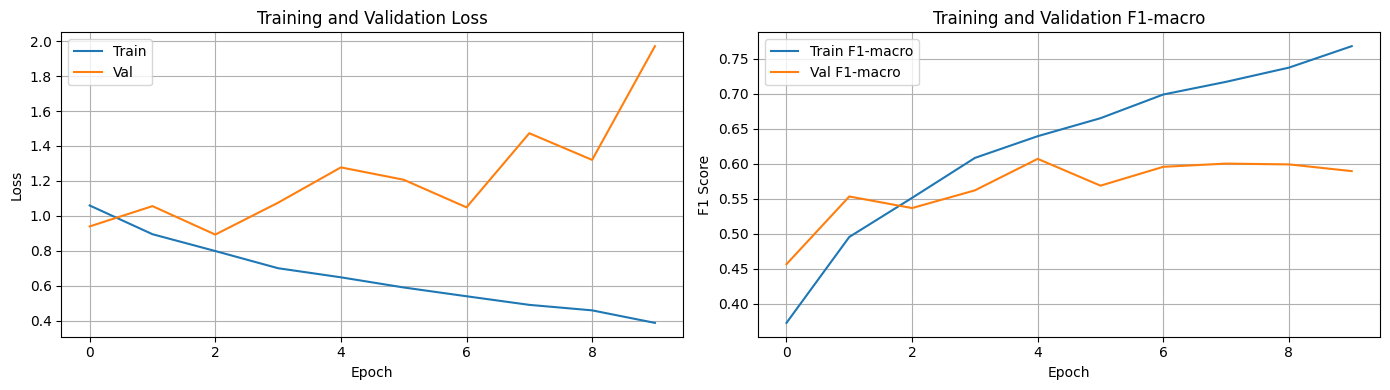

In [36]:
# Plot training history
if history['train_loss']:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # Loss
    ax1 = axes[0]
    ax1.plot(history['train_loss'], label='Train')
    ax1.plot(history['val_loss'], label='Val')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # F1 Score
    ax2 = axes[1]
    ax2.plot(history['train_f1_macro'], label='Train F1-macro')
    ax2.plot(history['val_f1_macro'], label='Val F1-macro')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.set_title('Training and Validation F1-macro')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

## 7. Evaluate on Test Set

In [37]:
# Load best model
model_path = MODELS_PATH / 'bilstm_best.pt'
if model_path.exists():
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
    print(f"Val F1-macro: {checkpoint['val_f1_macro']:.4f}")

Loaded best model from epoch 5
Val F1-macro: 0.6068


In [38]:
# Evaluate on test set
test_loss, test_f1_micro, test_f1_macro, test_preds, test_probs, test_labels = evaluate(
    model, test_loader, criterion, device
)

print("\n" + "=" * 60)
print("TEST SET RESULTS")
print("=" * 60)
print(f"Loss: {test_loss:.4f}")
print(f"F1-micro: {test_f1_micro:.4f}")
print(f"F1-macro: {test_f1_macro:.4f}")

Evaluating:   0%|          | 0/240 [00:00<?, ?it/s]


TEST SET RESULTS
Loss: 1.2364
F1-micro: 0.8507
F1-macro: 0.6117


In [39]:
# Detailed classification report for 3-class classification
print("\nDetailed Classification Report:")
print("=" * 60)
print(classification_report(
    test_labels, 
    test_preds,
    target_names=LABEL_NAMES,
    digits=4
))


Detailed Classification Report:
              precision    recall  f1-score   support

       CLEAN     0.9245    0.9258    0.9251      6438
   OFFENSIVE     0.3694    0.3755    0.3724       554
        HATE     0.5448    0.5305    0.5376       688

    accuracy                         0.8507      7680
   macro avg     0.6129    0.6106    0.6117      7680
weighted avg     0.8504    0.8507    0.8505      7680



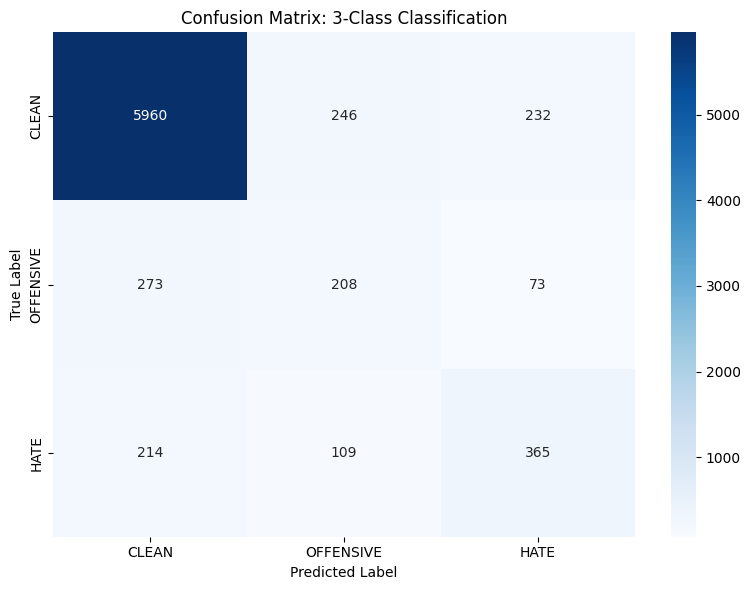


Per-class Accuracy:
  CLEAN: 5960/6438 (92.6%)
  OFFENSIVE: 208/554 (37.5%)
  HATE: 365/688 (53.1%)


In [40]:
# Confusion matrix for 3-class classification
fig, ax = plt.subplots(figsize=(8, 6))

cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues', ax=ax,
    xticklabels=LABEL_NAMES,
    yticklabels=LABEL_NAMES
)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix: 3-Class Classification')

plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-class Accuracy:")
for i, label_name in enumerate(LABEL_NAMES):
    correct = cm[i, i]
    total = cm[i].sum()
    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"  {label_name}: {correct}/{total} ({accuracy:.1f}%)")

In [41]:
# Analyze error cases
print("=" * 80)
print("ERROR ANALYSIS")
print("=" * 80)

# Create DataFrame with predictions
test_df_analysis = test_df.copy()
test_df_analysis['predicted_label'] = test_preds
test_df_analysis['true_label_name'] = test_df_analysis['label'].map({0: 'CLEAN', 1: 'OFFENSIVE', 2: 'HATE'})
test_df_analysis['predicted_label_name'] = test_df_analysis['predicted_label'].map({0: 'CLEAN', 1: 'OFFENSIVE', 2: 'HATE'})
test_df_analysis['correct'] = test_df_analysis['label'] == test_df_analysis['predicted_label']

# Add confidence scores
test_df_analysis['confidence'] = [test_probs[i][test_preds[i]] for i in range(len(test_preds))]
test_df_analysis['prob_clean'] = test_probs[:, 0]
test_df_analysis['prob_offensive'] = test_probs[:, 1]
test_df_analysis['prob_hate'] = test_probs[:, 2]

# Overall error rate
total_errors = (~test_df_analysis['correct']).sum()
error_rate = (total_errors / len(test_df_analysis)) * 100
print(f"\nTotal errors: {total_errors}/{len(test_df_analysis)} ({error_rate:.1f}%)")

# Error breakdown by true label
print("\n" + "-" * 80)
print("ERRORS BY TRUE LABEL:")
print("-" * 80)
for true_label in [0, 1, 2]:
    label_name = LABEL_NAMES[true_label]
    label_df = test_df_analysis[test_df_analysis['label'] == true_label]
    errors = (~label_df['correct']).sum()
    total = len(label_df)
    error_pct = (errors / total * 100) if total > 0 else 0
    
    print(f"\n{label_name} ({total} samples, {errors} errors = {error_pct:.1f}%):")
    
    # Where did the errors go?
    error_df = label_df[~label_df['correct']]
    if len(error_df) > 0:
        for pred_label in [0, 1, 2]:
            if pred_label != true_label:
                pred_name = LABEL_NAMES[pred_label]
                count = (error_df['predicted_label'] == pred_label).sum()
                pct = (count / errors * 100) if errors > 0 else 0
                print(f"  → Misclassified as {pred_name}: {count} ({pct:.1f}% of errors)")

print("\n" + "=" * 80)

ERROR ANALYSIS

Total errors: 1147/7680 (14.9%)

--------------------------------------------------------------------------------
ERRORS BY TRUE LABEL:
--------------------------------------------------------------------------------

CLEAN (6438 samples, 478 errors = 7.4%):
  → Misclassified as OFFENSIVE: 246 (51.5% of errors)
  → Misclassified as HATE: 232 (48.5% of errors)

OFFENSIVE (554 samples, 346 errors = 62.5%):
  → Misclassified as CLEAN: 273 (78.9% of errors)
  → Misclassified as HATE: 73 (21.1% of errors)

HATE (688 samples, 323 errors = 46.9%):
  → Misclassified as CLEAN: 214 (66.3% of errors)
  → Misclassified as OFFENSIVE: 109 (33.7% of errors)



In [42]:
# Show specific error examples for each confusion type
print("=" * 80)
print("ERROR EXAMPLES")
print("=" * 80)

def show_error_examples(true_label, pred_label, n=5):
    """Show n examples of a specific type of error."""
    true_name = LABEL_NAMES[true_label]
    pred_name = LABEL_NAMES[pred_label]
    
    errors = test_df_analysis[
        (test_df_analysis['label'] == true_label) & 
        (test_df_analysis['predicted_label'] == pred_label)
    ].sort_values('confidence', ascending=False)  # Show most confident errors first
    
    if len(errors) == 0:
        print(f"\nNo {true_name} → {pred_name} errors found")
        return
    
    print(f"\n{true_name} → {pred_name} ({len(errors)} errors)")
    print("-" * 80)
    
    for idx, row in errors.head(n).iterrows():
        print(f"\nText: {row['text'][:200]}...")
        print(f"True: {row['true_label_name']} | Predicted: {row['predicted_label_name']} (conf: {row['confidence']:.3f})")
        print(f"Probs → CLEAN: {row['prob_clean']:.3f}, OFFENSIVE: {row['prob_offensive']:.3f}, HATE: {row['prob_hate']:.3f}")

# Most problematic: OFFENSIVE misclassifications
print("\n" + "=" * 80)
print("OFFENSIVE MISCLASSIFICATIONS (main problem area)")
print("=" * 80)
show_error_examples(1, 0, n=8)  # OFFENSIVE → CLEAN
show_error_examples(1, 2, n=5)  # OFFENSIVE → HATE

# Other interesting error patterns
print("\n" + "=" * 80)
print("OTHER ERROR PATTERNS")
print("=" * 80)
show_error_examples(0, 1, n=5)  # CLEAN → OFFENSIVE (false positives)
show_error_examples(2, 1, n=5)  # HATE → OFFENSIVE
show_error_examples(2, 0, n=5)  # HATE → CLEAN (severe errors)

ERROR EXAMPLES

OFFENSIVE MISCLASSIFICATIONS (main problem area)

OFFENSIVE → CLEAN (273 errors)
--------------------------------------------------------------------------------

Text: Mua sắt vụn về làm phương tiện chiến đấu! Đắng lòng...
True: OFFENSIVE | Predicted: CLEAN (conf: 0.998)
Probs → CLEAN: 0.998, OFFENSIVE: 0.002, HATE: 0.000

Text: Anh em yếu sly ib...
True: OFFENSIVE | Predicted: CLEAN (conf: 0.998)
Probs → CLEAN: 0.998, OFFENSIVE: 0.002, HATE: 0.000

Text: Chiều Xuân rất đẹp, còn Hồng Nhung tôi không thể nhận ra !...
True: OFFENSIVE | Predicted: CLEAN (conf: 0.997)
Probs → CLEAN: 0.997, OFFENSIVE: 0.002, HATE: 0.000

Text: Like 10 năm chất Liek bằng đầu bùi...
True: OFFENSIVE | Predicted: CLEAN (conf: 0.997)
Probs → CLEAN: 0.997, OFFENSIVE: 0.003, HATE: 0.001

Text: Đào đất đóng gạch đi,đông về khối đứa cần ủ ấm....
True: OFFENSIVE | Predicted: CLEAN (conf: 0.997)
Probs → CLEAN: 0.997, OFFENSIVE: 0.003, HATE: 0.001

Text: Võ Xuân Hoan điên hả m...
True: OFFENSIVE | Pred

CONFIDENCE ANALYSIS


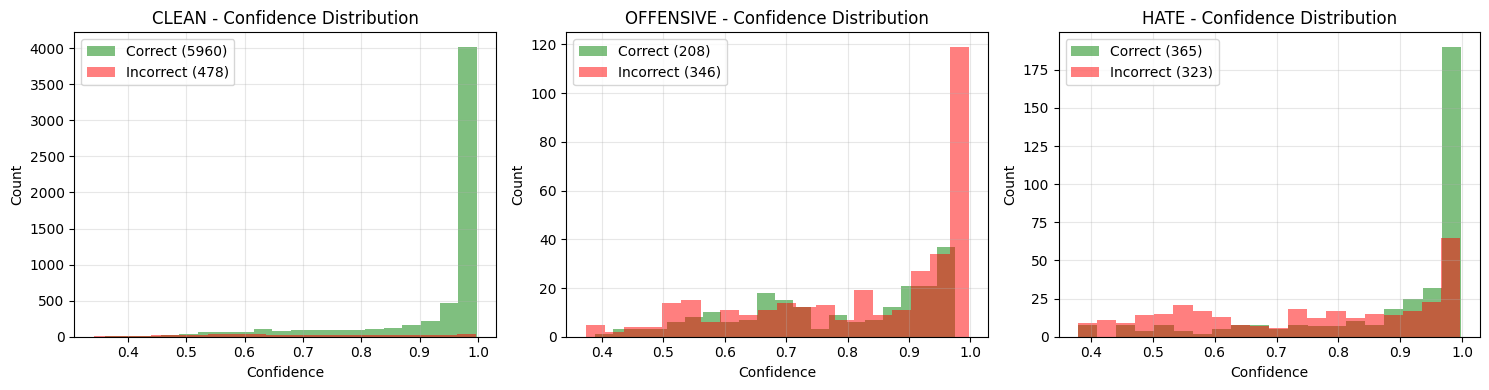


Average Confidence:
----------------------------------------
CLEAN:
  Correct:   0.928
  Incorrect: 0.696
  Gap:       0.232
OFFENSIVE:
  Correct:   0.777
  Incorrect: 0.830
  Gap:       0.052
HATE:
  Correct:   0.885
  Incorrect: 0.754
  Gap:       0.132


In [43]:
# Analyze confidence distribution for errors
print("=" * 80)
print("CONFIDENCE ANALYSIS")
print("=" * 80)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, label in enumerate([0, 1, 2]):
    ax = axes[idx]
    label_name = LABEL_NAMES[label]
    
    # Get correct and incorrect predictions for this label
    correct = test_df_analysis[(test_df_analysis['label'] == label) & test_df_analysis['correct']]
    incorrect = test_df_analysis[(test_df_analysis['label'] == label) & ~test_df_analysis['correct']]
    
    if len(correct) > 0:
        ax.hist(correct['confidence'], bins=20, alpha=0.5, label=f'Correct ({len(correct)})', color='green')
    if len(incorrect) > 0:
        ax.hist(incorrect['confidence'], bins=20, alpha=0.5, label=f'Incorrect ({len(incorrect)})', color='red')
    
    ax.set_xlabel('Confidence')
    ax.set_ylabel('Count')
    ax.set_title(f'{label_name} - Confidence Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print average confidence for correct vs incorrect
print("\nAverage Confidence:")
print("-" * 40)
for label in [0, 1, 2]:
    label_name = LABEL_NAMES[label]
    correct = test_df_analysis[(test_df_analysis['label'] == label) & test_df_analysis['correct']]
    incorrect = test_df_analysis[(test_df_analysis['label'] == label) & ~test_df_analysis['correct']]
    
    correct_conf = correct['confidence'].mean() if len(correct) > 0 else 0
    incorrect_conf = incorrect['confidence'].mean() if len(incorrect) > 0 else 0
    
    print(f"{label_name}:")
    print(f"  Correct:   {correct_conf:.3f}")
    print(f"  Incorrect: {incorrect_conf:.3f}")
    print(f"  Gap:       {abs(correct_conf - incorrect_conf):.3f}")

## 8. Save Model for Deployment

In [44]:
# Save complete model package for deployment
deployment_path = MODELS_PATH / 'deployment'
deployment_path.mkdir(parents=True, exist_ok=True)

# Save model weights
torch.save(model.state_dict(), deployment_path / 'model_weights.pt')

# Save model config
config = {
    'model_type': 'BiLSTMClassifier',
    'vocab_size': len(vocab),
    'num_labels': NUM_CLASSES,
    'label_names': LABEL_NAMES,
    'max_seq_length': MAX_SEQ_LENGTH,
    'padding_idx': vocab.pad_idx,
    'task': '3-class classification',
    **model_config
}

with open(deployment_path / 'config.json', 'w') as f:
    json.dump(config, f, indent=2)

# Copy vocabulary
vocab.save(deployment_path / 'vocab.json')

print("Saved deployment package:")
for f in deployment_path.iterdir():
    size = f.stat().st_size / 1024  # KB
    print(f"  - {f.name}: {size:.1f} KB")

Saved deployment package:
  - vocab.json: 562.4 KB
  - model_weights.pt: 44620.3 KB
  - config.json: 0.3 KB


In [45]:
# Test inference - 3-class classification
print("Testing inference...")

test_comments = [
    "Sản phẩm này tốt lắm, mình rất thích!",
    "Đm thằng này ngu vl",
    "Mấy thằng người Bắc toàn lừa đảo",
    "Cảm ơn bạn đã chia sẻ thông tin hữu ích",
]

model.eval()
for comment in test_comments:
    # Preprocess
    processed = preprocessor.preprocess(comment)
    
    # Tokenize
    tokens = vocab.encode(processed)
    if len(tokens) > MAX_SEQ_LENGTH:
        tokens = tokens[:MAX_SEQ_LENGTH]
    
    # Pad
    attention_mask = [1] * len(tokens)
    padding = MAX_SEQ_LENGTH - len(tokens)
    tokens = tokens + [vocab.pad_idx] * padding
    attention_mask = attention_mask + [0] * padding
    
    # Predict
    input_ids = torch.tensor([tokens], dtype=torch.long).to(device)
    mask = torch.tensor([attention_mask], dtype=torch.long).to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, mask)
        logits = outputs['logits'][0]
        probs = torch.softmax(logits, dim=0).cpu().numpy()
        pred_class = int(torch.argmax(logits).item())
    
    print(f"\nComment: {comment}")
    print(f"Prediction: {LABEL_NAMES[pred_class]}")
    print(f"Probabilities:")
    for i, (label_name, prob) in enumerate(zip(LABEL_NAMES, probs)):
        print(f"  {label_name}: {prob:.3f}")

Testing inference...

Comment: Sản phẩm này tốt lắm, mình rất thích!
Prediction: CLEAN
Probabilities:
  CLEAN: 0.996
  OFFENSIVE: 0.003
  HATE: 0.001

Comment: Đm thằng này ngu vl
Prediction: HATE
Probabilities:
  CLEAN: 0.000
  OFFENSIVE: 0.003
  HATE: 0.996

Comment: Mấy thằng người Bắc toàn lừa đảo
Prediction: HATE
Probabilities:
  CLEAN: 0.002
  OFFENSIVE: 0.005
  HATE: 0.993

Comment: Cảm ơn bạn đã chia sẻ thông tin hữu ích
Prediction: CLEAN
Probabilities:
  CLEAN: 0.996
  OFFENSIVE: 0.003
  HATE: 0.001


## Done!

The trained model is saved in `data/models/deployment/`. Files:
- `model_weights.pt` - Model weights
- `config.json` - Model configuration
- `vocab.json` - Vocabulary

Next steps:
1. Download these files if running on Colab
2. Place them in your local `data/models/deployment/` folder
3. Run the FastAPI service